# Feed-forward сети

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR100 as dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
!pip install -qq einops
from einops import rearrange, repeat

     |████████████████████████████████| 41 kB 355 kB/s 


In [ ]:
transforms = T.Compose([#T.Resize((72,72)),
                        T.RandomHorizontalFlip(p=0.3),
                        T.RandomRotation(10),
                        T.ToTensor(),
                        T.Normalize(0.5, 0.5)])

valid_transforms = T.Compose([#T.Resize((72,72)),
                              T.ToTensor(),
                              T.Normalize(0.5, 0.5)])

inverse = T.Compose([T.Normalize(-1,2),
                     T.ToPILImage()])

In [ ]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [ ]:
train_data = dataset('./', train=True, download=True, transform=transforms)
valid_data = dataset('./', train=False, download=False, transform=valid_transforms)

train_dl = DataLoader(train_data, batch_size=256, shuffle=True)  # as in paper
valid_dl = DataLoader(valid_data, batch_size=256)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./


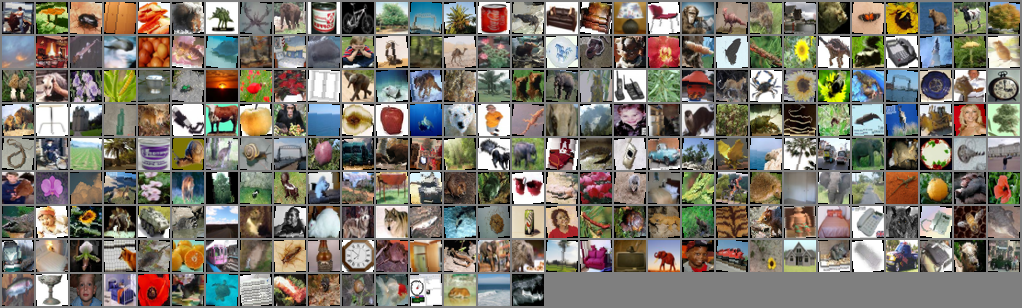

In [ ]:
images, labels = next(iter(train_dl))

inverse(torchvision.utils.make_grid(images, nrow=30))

In [ ]:
class LeakyReLU(nn.Module):
    def __init__(self, min_slope=0.1, max_slope=0.5):
        super(LeakyReLU, self).__init__()
        self.min_slope = min_slope
        self.max_slope = max_slope

    def forward(self, x):
        return torch.maximum(self.min_slope*x, self.max_slope*x)  # Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)

In [ ]:
# baseline
in_features = 3*32*32
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=in_features, out_features=in_features//4),
    LeakyReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=in_features//4, out_features=in_features//8),
    LeakyReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=in_features//8, out_features=100)
).to(device)

In [ ]:
# https://arxiv.org/pdf/2210.07240.pdf : training ViT on small datasets

class MLP(nn.Module):
    def __init__(self, dim, dropout, relu=False):
        super(MLP, self).__init__()
        self.dim = dim
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(dim, dim//2)
        self.fc2 = nn.Linear(dim//2, dim//4)
        self.relu = nn.ReLU() if relu else nn.GELU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))  # add (inputs + x)?
        return x

class VisualTransformer(nn.Module):
    def __init__(self, img_size, in_channels, embedding_dim, num_heads, mlp_dim,
                 block_num, patch_dim, classification=True, num_classes=10, dropout=0.1):
        super(VisualTransformer, self).__init__()

        self.patch_dim = patch_dim
        self.classification = classification
        self.num_tokens = (img_size // patch_dim) ** 2
        self.token_dim = in_channels * (patch_dim ** 2)

        self.projection = nn.Linear(self.token_dim, embedding_dim)

        self.pos_embedding = nn.Parameter(torch.randn(self.num_tokens + 1, embedding_dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        self.dropout = nn.Dropout(p=dropout)

        encoder_layer = nn.TransformerEncoderLayer(embedding_dim,   # norm->mha (softmax(q@k^T/sqrt(dk))@v))->add&norm->ffn->add&norm
                                                   nhead=num_heads, 
                                                   dim_feedforward=mlp_dim, 
                                                   dropout=dropout,
                                                   activation=nn.GELU(), 
                                                   batch_first=True)  # relu
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=block_num)  # sequence of num_layers encoder layers
        # head modules v1
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, num_classes, bias=True),
        )
        # head moduled v2
        self.norm = nn.LayerNorm(embedding_dim)
        self.mlp = MLP(self.num_tokens * embedding_dim, dropout=dropout)
        self.head = nn.Linear((self.num_tokens * embedding_dim) // 4, num_classes)  # //4 with MLP

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, x):
        img_patches = rearrange(x, 'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)', patch_x=self.patch_dim,
                                patch_y=self.patch_dim)

        batch_size, tokens, _ = img_patches.shape

        project = self.projection(img_patches)
        token = repeat(self.cls_token, 'b ... -> (b batch_size) ...', batch_size=batch_size)

        patches = torch.cat([token, project], dim=1)
        patches += self.pos_embedding[:tokens + 1, :]

        x = self.dropout(patches)
        x = self.transformer(x)

        # two versions of classification: with CLS token or all other tokens
        if self.classification:
            x = self.mlp_head(x[:, 0, :])  # use CLS token (that collected usefull info from other tokens during attention calc.) for cls task
        else:
            x = self.dropout(self.norm(x[:, 1:, :]))  # use all other extracted visual features (has to be modified for specific task)
            x = rearrange(x, 'b t e -> b (t e)')
            x = self.mlp(x)  # optional
            x = self.head(x)

        return x

In [ ]:
model = VisualTransformer(32, 3, 64, 4, 64, 2, 4, True, 100, 0.2).to(device)  # patch = 4 as in paper, except dropout

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)  # like in paper, except adam -> adamw
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, min_lr=1e-7)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1000, eta_min=1e-6)

In [ ]:
for epoch in range(100):
    print(f"Epoch {epoch+1}/100")
    model.train()
    train_losses, train_accuracies = [], []
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        pred = model(images)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        accuracy = (torch.max(pred, 1)[1] == labels).float().mean()
        train_accuracies.append(accuracy.item())
        train_losses.append(loss.item())

    model.eval()
    valid_losses, valid_accuracies = [], []
    with torch.no_grad():
        for images, labels in valid_dl:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = criterion(pred, labels)
            accuracy = (torch.max(pred, 1)[1] == labels).float().mean()
            valid_accuracies.append(accuracy.item())
            valid_losses.append(loss.item())
    scheduler.step(np.mean(valid_losses))
    print(f"train loss: {np.mean(train_losses):.4f}, train acc: {np.mean(train_accuracies):.4f};", \
          f"valid loss: {np.mean(valid_losses):.4f}, valid acc: {np.mean(valid_accuracies):.4f}")

Epoch 1/100
train loss: 4.2027, train acc: 0.0563; valid loss: 3.9645, valid acc: 0.0851
Epoch 2/100
train loss: 3.9111, train acc: 0.0911; valid loss: 3.8151, valid acc: 0.1087
Epoch 3/100
train loss: 3.7859, train acc: 0.1133; valid loss: 3.6849, valid acc: 0.1370
Epoch 4/100
train loss: 3.6811, train acc: 0.1295; valid loss: 3.6000, valid acc: 0.1464
Epoch 5/100
train loss: 3.6007, train acc: 0.1424; valid loss: 3.5023, valid acc: 0.1676
Epoch 6/100
train loss: 3.5310, train acc: 0.1544; valid loss: 3.4389, valid acc: 0.1770
Epoch 7/100
train loss: 3.4592, train acc: 0.1671; valid loss: 3.3623, valid acc: 0.1925
Epoch 8/100
train loss: 3.4092, train acc: 0.1751; valid loss: 3.3338, valid acc: 0.2019
Epoch 9/100
train loss: 3.3728, train acc: 0.1845; valid loss: 3.3051, valid acc: 0.2017
Epoch 10/100
train loss: 3.3290, train acc: 0.1921; valid loss: 3.2645, valid acc: 0.2121
Epoch 11/100
train loss: 3.2905, train acc: 0.1990; valid loss: 3.2097, valid acc: 0.2211
Epoch 12/100
train 

**SWIN transformer** for large images (obviously, not for cifar100 😖 )

In [ ]:
# https://github.com/berniwal/swin-transformer-pytorch/blob/master/swin_transformer_pytorch/swin_transformer.py
# great implementation (upvote and fork), as it were difficulties with implementing window! attention operations

# global explanation: https://habr.com/ru/post/599057/

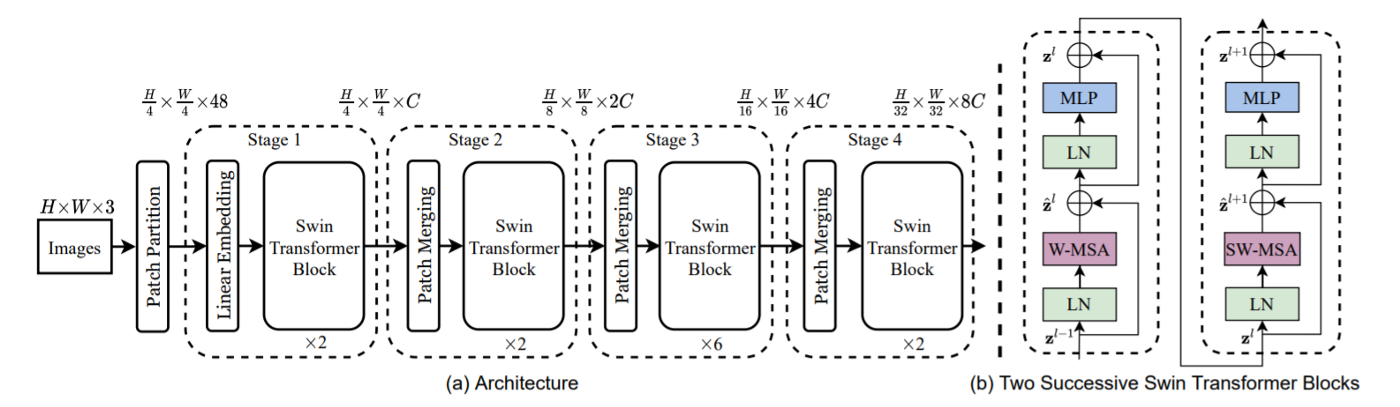

In [ ]:
def create_mask(window_size, displacement, upper_lower, left_right):
    """ 
    creates mask to hide non-neigboring tokens during 
    windowed attention operations
    """
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = -np.inf
        mask[:-displacement * window_size, -displacement * window_size:] = -np.inf

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = -np.inf
        mask[:, :-displacement, :, -displacement:] = -np.inf
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask

def get_relative_distances(window_size):
    """ 
    - get all indices of window with given square size 
    - compute shifted indices (distancrs) along all axes
    """
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances

In [ ]:
class CyclicShift(nn.Module):
    """ shifts input along 1 and 2 axis with 'displacement' steps """
    def __init__(self, displacement):
        super(CyclicShift, self).__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))

class FeedForward(nn.Module):
    """ FFN for transformer block """
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super(FeedForward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class WindowAttention(nn.Module):
    """ attention with respect to window partitioning """
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super(WindowAttention, self).__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2  # window stride
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            # create masks to hide non-neighboring tokens while performing mha weights calculation
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)  # roll input: shifted diagonlly windows to make tokens interact

        b, n_h, n_w, _, h = *x.shape, self.heads  # channels last

        qkv = self.to_qkv(x).chunk(3, dim=-1)  # split into 3 channel slices after linear projection
        nw_h = n_h // self.window_size  # num height patches
        nw_w = n_w // self.window_size  # num width pathches

        q, k, v = map(  # split qkv into q,k,v with patch rearrangement: multihead patches
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        dots = torch.einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale  # q@kT / sqrt(d_k)

        if self.relative_pos_embedding:  # add relative (windowed) pos encoding: q@kT / sqrt(d_k) + B (learnable bias matrix) 
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding  # otherwise: casual pos encoding

        if self.shifted:  # add masks
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)  # w = softmax(q@kT/sqrt(d_k))

        out = torch.einsum('b h w i j, b h w j d -> b h w i d', attn, v)  # w @ v
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)  # rearrenge to [b,h,w,c]
        out = self.to_out(out)  # final projection

        if self.shifted:  # shift back
            out = self.cyclic_back_shift(out)
        return out

In [ ]:
class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super(SwinBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attention_block = WindowAttention(dim=dim,
                                               heads=heads,
                                               head_dim=head_dim,
                                               shifted=shifted,
                                               window_size=window_size,
                                               relative_pos_embedding=relative_pos_embedding)
        self.mlp_block = FeedForward(dim=dim, hidden_dim=mlp_dim)

    def forward(self, x):
        x1 = self.norm1(x)
        x1 = self.attention_block(x1)
        x = x + x1
        x1 = self.norm2(x)
        x1 = self.mlp_block(x1)
        x = x + x1
        return x

class PatchMerging(nn.Module):
    """ merging input patches into [b,c,h,w] with linear projection """
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super(PatchMerging, self).__init__()
        self.downscaling_factor = downscaling_factor
        # Unfold operation: (B,C×∏(kernel_size),L): [1, 3, 32, 32] -> [1, 3*(2*2), -1] = [1, 12, 256]
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)  # unfold + reshape to channels last
        x = self.linear(x)  # add projection
        return x

In [ ]:
class SwinEncoderBlock(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super(SwinEncoderBlock, self).__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, 
                                            out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):  # create base encoder stack
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, 
                          heads=num_heads, 
                          head_dim=head_dim, 
                          mlp_dim=hidden_dimension * 4,
                          shifted=False, 
                          window_size=window_size, 
                          relative_pos_embedding=relative_pos_embedding), # with shift
                SwinBlock(dim=hidden_dimension, 
                          heads=num_heads, 
                          head_dim=head_dim, 
                          mlp_dim=hidden_dimension * 4,
                          shifted=True, 
                          window_size=window_size, 
                          relative_pos_embedding=relative_pos_embedding),  # no shift
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:  # apply both sequentially
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)  # return to channels first

In [ ]:
class SwinTransformer(nn.Module):
    """ 
    Now all together 
    Applying several encoder layers is useful to get different scaled features
    for segmentation or object detection tasks
    """
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=100, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        self.stage1 = SwinEncoderBlock(in_channels=channels, 
                                       hidden_dimension=hidden_dim, 
                                       layers=layers[0],
                                       downscaling_factor=downscaling_factors[0], 
                                       num_heads=heads[0], 
                                       head_dim=head_dim,
                                       window_size=window_size, 
                                       relative_pos_embedding=relative_pos_embedding)
        self.stage2 = SwinEncoderBlock(in_channels=hidden_dim, 
                                       hidden_dimension=hidden_dim * 2, 
                                       layers=layers[1],
                                       downscaling_factor=downscaling_factors[1], 
                                       num_heads=heads[1], 
                                       head_dim=head_dim,
                                       window_size=window_size, 
                                       relative_pos_embedding=relative_pos_embedding)
        self.stage3 = SwinEncoderBlock(in_channels=hidden_dim * 2, 
                                       hidden_dimension=hidden_dim * 4, 
                                       layers=layers[2],
                                       downscaling_factor=downscaling_factors[2], 
                                       num_heads=heads[2], 
                                       head_dim=head_dim,
                                       window_size=window_size, 
                                       relative_pos_embedding=relative_pos_embedding)
        self.stage4 = SwinEncoderBlock(in_channels=hidden_dim * 4, 
                                       hidden_dimension=hidden_dim * 8, 
                                       layers=layers[3],
                                       downscaling_factor=downscaling_factors[3], 
                                       num_heads=heads[3], 
                                       head_dim=head_dim,
                                       window_size=window_size, 
                                       relative_pos_embedding=relative_pos_embedding)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim * 8),
            nn.Linear(hidden_dim * 8, num_classes)
        )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        # after extracting features with different scales move to classification task
        x = x.mean(dim=[2, 3])
        return self.mlp_head(x)

In [ ]:
# swin = SwinTransformer(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24)).to(device)  # swin tiny [224, 224]
# swin = SwinTransformer(hidden_dim=96, layers=(2, 2, 18, 2), heads=(3, 6, 12, 24)).to(device)  # swin small
# swin = SwinTransformer(hidden_dim=128, layers=(2, 2, 18, 2), heads=(4, 8, 16, 32)).to(device)  # swin big
# swin = SwinTransformer(hidden_dim=192, layers=(2, 2, 18, 2), heads=(6, 12, 24, 48)).to(device)  # swin large

# totally reduced model for demonstration purposes
swin = SwinTransformer(
                    hidden_dim=64,
                    layers=(2, 2, 2, 2),
                    heads=(4, 4, 4, 4),
                    channels=3,
                    num_classes=100,
                    head_dim=32,
                    window_size=2,
                    downscaling_factors=(2, 2, 2, 2),
                    relative_pos_embedding=True
).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(swin.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1000, eta_min=1e-6)

In [ ]:
for epoch in range(100):
    print(f"Epoch {epoch+1}/100")
    swin.train()
    train_losses, train_accuracies = [], []
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        pred = swin(images)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        accuracy = (torch.max(pred, 1)[1] == labels).float().mean()
        train_accuracies.append(accuracy.item())
        train_losses.append(loss.item())

    swin.eval()
    valid_losses, valid_accuracies = [], []
    with torch.no_grad():
        for images, labels in valid_dl:
            images, labels = images.to(device), labels.to(device)
            pred = swin(images)
            loss = criterion(pred, labels)
            accuracy = (torch.max(pred, 1)[1] == labels).float().mean()
            valid_accuracies.append(accuracy.item())
            valid_losses.append(loss.item())
    scheduler.step(np.mean(valid_losses))
    print(f"train loss: {np.mean(train_losses):.4f}, train acc: {np.mean(train_accuracies):.4f} | ", \
          f"valid loss: {np.mean(valid_losses):.4f}, valid acc: {np.mean(valid_accuracies):.4f}")

Epoch 1/100
train loss: 4.2291, train acc: 0.0528 |  valid loss: 3.9995, valid acc: 0.0797
Epoch 2/100
train loss: 3.8426, train acc: 0.1026 |  valid loss: 3.7610, valid acc: 0.1223
Epoch 3/100
train loss: 3.6399, train acc: 0.1354 |  valid loss: 3.5425, valid acc: 0.1542
Epoch 4/100
train loss: 3.4654, train acc: 0.1658 |  valid loss: 3.4286, valid acc: 0.1716
Epoch 5/100
train loss: 3.3943, train acc: 0.1810 |  valid loss: 3.4068, valid acc: 0.1829
Epoch 6/100
train loss: 3.3249, train acc: 0.1944 |  valid loss: 3.3448, valid acc: 0.1974
Epoch 7/100
train loss: 3.3514, train acc: 0.1894 |  valid loss: 3.4044, valid acc: 0.1878
Epoch 8/100
train loss: 3.2728, train acc: 0.2049 |  valid loss: 3.2151, valid acc: 0.2252
Epoch 9/100
train loss: 3.1614, train acc: 0.2216 |  valid loss: 3.1676, valid acc: 0.2234
Epoch 10/100
train loss: 3.1291, train acc: 0.2297 |  valid loss: 3.0877, valid acc: 0.2377
Epoch 11/100
train loss: 3.0572, train acc: 0.2468 |  valid loss: 3.0708, valid acc: 0.24

**Swin Transformer pretrained**

In [ ]:
!pip install -qq timm
import timm

HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)  # expected values across channels
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)  # standard deviations across channels

swin = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) 

Using cache found in /root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main


In [ ]:
transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD),
])

train_data = dataset('./', train=True, download=True, transform=transforms)
valid_data = dataset('./', train=False, download=False, transform=transforms)

train_dl = DataLoader(train_data, batch_size=256, shuffle=True)  # as in paper
valid_dl = DataLoader(valid_data, batch_size=256)

Files already downloaded and verified


In [ ]:
for param in swin.parameters():  # freeze model weights
    param.requires_grad = False

n_inputs = swin.head.in_features
swin.head = nn.Sequential(
                nn.Linear(n_inputs, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 100)
)
swin = swin.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(swin.head.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1000, eta_min=1e-6)

In [ ]:
for epoch in range(50):
    print(f"Epoch {epoch+1}/50")
    swin.train()
    train_losses, train_accuracies = [], []
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        pred = swin(images)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        accuracy = (torch.max(pred, 1)[1] == labels).float().mean()
        train_accuracies.append(accuracy.item())
        train_losses.append(loss.item())

    swin.eval()
    valid_losses, valid_accuracies = [], []
    with torch.no_grad():
        for images, labels in valid_dl:
            images, labels = images.to(device), labels.to(device)

            pred = swin(images)
            loss = criterion(pred, labels)

            accuracy = (torch.max(pred, 1)[1] == labels).float().mean()
            valid_accuracies.append(accuracy.item())
            valid_losses.append(loss.item())
    scheduler.step(np.mean(valid_losses))
    print(f"train loss: {np.mean(train_losses):.4f}, train acc: {np.mean(train_accuracies):.4f} | ", \
          f"valid loss: {np.mean(valid_losses):.4f}, valid acc: {np.mean(valid_accuracies):.4f}")

Epoch 1/50
train loss: 4.6189, train acc: 0.0090 |  valid loss: 4.6149, valid acc: 0.0085
Epoch 2/50
